# Predicting Sentiments about Brands and Products on Twitter

We four intrepid data scientists, as a project for our data science intensive bootcamp through Flatiron school, set out to create a model that could determine how people feel about products or brands through their tweets.  Twitter is gold mine of emotional sentiment, as users impulsively express themselves in short, terse terms.  Tweets about given products are easy to collect as users use hashtags to communicate the topics of their expression.

We created a model when given a tweet or series of tweets and a product would determine how the user felt about that product.  This is trivial for a human to accomplish, but our model can do this for thousands or even millions of tweets in a small amount of time.  

This is not a trival problem.  Twitterspeak is rife with spelling errors, shortened words, acronyms, hashtags, and very specific words and proper nouns.  These are hard or impossible for a model to learn and are even confusing for humans much of the time.  Emotions are also complicated and a tweet may have a mix of emotions, ambiguous emotions, or conditional emotions.  The spectrum of feeling is much greater than our categories of positive, negative, or neutral.

Emotions are also relative.  Consier the phrase, "iPhones are better than Android phones."  Is this a positive or a negative tweet?  It depends!  This is why we chose to give our model a clue to which product we want the emotions to be classified in reference to.  We used the product name supplied in the 'product' column of our table to replace instances of that product in the tweet test with 'targetproduct'.  This helped our model to contextualize emotions and deal with this relativity.  

A model only learns as well as it's labels, and our data was labeled by humans.  Each human may have a different interpretation of a tweet.  The data was most likely labeled by different humans, and so there may be different opinions about the emotional context of a tweet expressed by different human labelers.

These considerations make this problem particularly sticky, and we are proud of the success that our models had in decifering the tweets.  As is often true with NLP problems, the structure of the model is often less important than how the data is prepared.

We tried many different approaches to this problem, from recurrent neural networks to convolutional neural networks, to a simple logistic regression model.  Each used model approached the problem in a different way, but they all were able to classify over 3/5ths of tweets correctly, giving a client a general sense, over a large sampling of tweets, what the sentiment is about their product in the twitterverse.

Load dependencies

In [2]:
import pandas as pd
import numpy as np

import keras
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, optimizers, layers
from keras.preprocessing import text, sequence
from keras.utils import plot_model
import kerastuner as kt

import IPython


from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import re

from nltk import pos_tag
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer 

from gensim.models import word2vec

from IPython.display import display 

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
import sys
sys.path.append("../..")


from src.model_evaluation import *
from src.data_preprocessing import *

sns.set(context = 'notebook', style = 'whitegrid')
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows',50)

np.random.seed(111)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\caell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\caell\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\caell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data Exploration

# Data Preparation

# RNN Model:
We thought a sequential model would be able to understand tweets and draw out their emotional sentiment by reading them like a human, in the order they are written.  Further, like a human, we wanted them to be able to retroactively assign context to words.  Because of this we chose a Bidirectional Long-Short Term Memory, or LSTM model.  These models have memory cells that allow them to carry information about previous words forward in order to understand later words in different ways.  The bidirectionality of this model allowed it to do this front to back and back to front simultaneously.

We present here our best RNN model, but it was not the only we tried.  Please refer to josh_LSTM_models.ipynb in the notebooks/exploratory folder to see more models.  These include models with pre-trained embedding layers, deeper models with more neurons, and models tuned with the Keras Tuner package from Tensorflow.  None of these performed as well as the relatively simple model we present below.

### Preparing the data
A computer model does not do well analyzing actual text, but researchers have developed wonderful ways to turn words into numbers without losing too much of their meaning.  The below code loads data from a .csv table, splits it into training, validation, and testing data, and tokenizes each tweet into numeric form.  

In [10]:
df = pd.read_csv('../../data/targeted_combined_no_lem.csv')
df.dropna(inplace = True)

sequence_len = 128

X = df['txt_cleaned']
y = df['emotion']

tokenizer = text.Tokenizer()

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.25)
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, random_state = 42, test_size = 0.25)

#tokenize full X_train
tokenizer.fit_on_texts(list(X))
list_tokenized_X_train = tokenizer.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(list_tokenized_X_train, maxlen=128)

#Tokenize training features
tokenized_X_t = tokenizer.texts_to_sequences(X_t)
X_t = sequence.pad_sequences(tokenized_X_t, maxlen=128)

#Tokenize validation features
tokenized_X_val = tokenizer.texts_to_sequences(X_val)
X_val = sequence.pad_sequences(tokenized_X_val, maxlen=128)

#Tokenize hold out set
tokenized_X_test = tokenizer.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(tokenized_X_test, maxlen=128)

### The LSTM RNN Model
Below, we create the model itself.  It starts with an embedding layer.  This layer is perhaps the most crucial as it embeds each tokenized word into a high dimensional space.  Each dimension of this space represents a relationship between words.  "Ear" and "sound" might differ along the same dimension as "eye" and "image".  How the model actually embeds the words is learned by the model itself by looking at how words relate in the text, in this case the 22000 or so tweet we gave it to learn from.

The next layer reads the tweets and refers to the values in the embedding layer to make sense of them.  The LSTM layer has a memory, so it can change its understanding of a word based on the words it has read previously.  The bidirectional wrapper for this layer allows it to do this with the tweet both forward and backward.  A given word produces an output based on both the words that come after it, and the words that come before it.  This is similar to how a human makes sense of a text it reads, retroactively contextualizing previously read passages.

The dense layer allows the model to abstract what it learns to some degree before selecting a prediction to output.

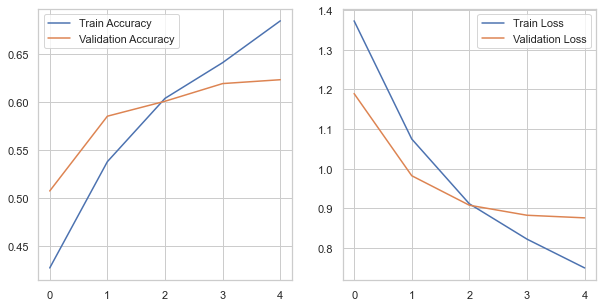

In [21]:
def make_RNN():
    model = Sequential()
    model.add(Embedding(len(tokenizer.word_index.keys())+1, sequence_len))
    model.add(Bidirectional(LSTM(units=5, 
                                 return_sequences=True, 
                                 dropout=0.2,
                                 recurrent_regularizer = regularizers.l1_l2(l1=1e-2,l2=1e-2)
                                 )))
    model.add(GlobalMaxPool1D())
    model.add(Dense(5, activation='relu',
              kernel_regularizer = regularizers.l1_l2(l1=1e-3,l2=1e-3)))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

    return model

RNN =  make_RNN()

history = RNN.fit(X_t, y_t,
                     epochs = 5,
                     batch_size = 100,
                     validation_data = (X_val,y_val),
                     verbose = 0)

graph_model_history(history)

Statistics for RNN


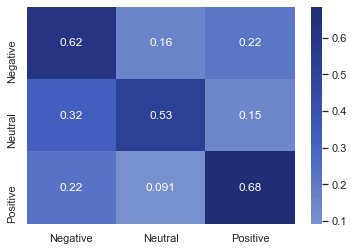

model validation accuracy is: 0.6187190375088464


In [22]:
y_pred = RNN.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
print('Statistics for RNN')
plot_confusion_matrix(y_test,y_pred)
print(f'model validation accuracy is: {accuracy_score(y_test,y_pred)}')

### RNN evaluation:
This model does not perform as well as we might have hoped.  It successfully classifies tweets about 62% of the time, which is okay, but not great.  Random chance would classify tweets correctly 33% of the time, it is definitely better than that.  It doesn't seem to have a great bias toward any one classification, scoring reasonably evenly across categories, which is good.  With this, we turn to another model architecture.